## Divergence of the weights on Mnist

Skeleton borrowed from Flax tutorials distributed under Apache License 2.0: https://github.com/google/flax/tree/main/examples/mnist



In [ ]:
!pip install -q flax

     |████████████████████████████████| 202 kB 5.4 MB/s 
     |████████████████████████████████| 9.1 MB 30.3 MB/s 
     |████████████████████████████████| 596 kB 52.4 MB/s 
     |████████████████████████████████| 145 kB 62.9 MB/s 
     |████████████████████████████████| 217 kB 54.1 MB/s 
     |████████████████████████████████| 51 kB 3.4 MB/s 
     |████████████████████████████████| 72 kB 634 kB/s 


In [ ]:
import jax
import jax.numpy as jnp                # JAX NumPy

from flax import linen as nn           # The Linen API
from flax.training import train_state  # Useful dataclass to keep train state

import numpy as np                     # Ordinary NumPy
import optax                           # Optimizers
import tensorflow as tf

In [ ]:
tf.config.experimental.set_visible_devices([], 'GPU')
use_float64 = True
if use_float64:
  from jax.config import config
  config.update("jax_enable_x64", True)
  dtype = jnp.float64
else:
  dtype = jnp.float32

In [ ]:
class CNN(nn.Module):
  """A simple CNN model."""

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=32, kernel_size=(3, 3), dtype=dtype)(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3), dtype=dtype)(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=256, dtype=dtype)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10, dtype=dtype)(x)
    return x

In [ ]:
def cross_entropy_loss(*, logits, labels):
  labels_onehot = jax.nn.one_hot(labels, num_classes=10)
  return optax.softmax_cross_entropy(logits=logits, labels=labels_onehot).mean()

In [ ]:
def compute_metrics(*, logits, labels):
  loss = cross_entropy_loss(logits=logits, labels=labels)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  metrics = {
      'loss': loss,
      'accuracy': accuracy,
  }
  return metrics

In [ ]:
def get_datasets():
  """Load MNIST train and test datasets into memory."""
  (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
  train_ds = {'image':x_train.reshape((-1,28,28,1)), 'label':y_train}
  test_ds = {'image':x_test.reshape((-1,28,28,1)), 'label':y_test}
  if dtype == jnp.float32:
    train_ds['image'] = jnp.float32(train_ds['image']) / 255.
    test_ds['image'] = jnp.float32(test_ds['image']) / 255.
  else:
    train_ds['image'] = jnp.float64(train_ds['image']) / 255.
    test_ds['image'] = jnp.float64(test_ds['image']) / 255.
  train_ds['label'] = jnp.array(train_ds['label'])
  test_ds['label'] = jnp.array(test_ds['label'])
  return train_ds, test_ds

In [ ]:
def create_train_state(rng, tx):
  """Creates initial `TrainState`."""
  cnn = CNN()
  params = cnn.init(rng, jnp.ones([1, 28, 28, 1]))['params']
  return train_state.TrainState.create(
      apply_fn=cnn.apply, params=params, tx=tx)

In [ ]:
@jax.jit
def train_step(state, batch):
  """Train for a single step."""
  def loss_fn(params):
    logits = CNN().apply({'params': params}, batch['image'])
    loss = cross_entropy_loss(logits=logits, labels=batch['label'])
    return loss, logits
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (_, logits), grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  metrics = compute_metrics(logits=logits, labels=batch['label'])
  return state, metrics

In [ ]:
def eval_step(params, batch):
  logits = CNN().apply({'params': params}, batch['image'])
  return compute_metrics(logits=logits, labels=batch['label'])

In [ ]:
def train_epoch(state, train_ds, batch_size, epoch, rng):
  """Train for a single epoch."""
  train_ds_size = len(train_ds['image'])
  steps_per_epoch = train_ds_size // batch_size

  perms = jax.random.permutation(rng, train_ds_size)
  perms = perms[:steps_per_epoch*batch_size]  # drop last batch
  train_ds['image'] = train_ds['image'][perms]
  train_ds['label'] = train_ds['label'][perms]
  batch_metrics = []
  for batch_idx in range(0, train_ds_size, batch_size):
    batch = {k: v[batch_idx:batch_idx+batch_size, ...] for k, v in train_ds.items()}
    state, metrics = train_step(state, batch)
    batch_metrics.append(metrics)
  del train_ds

  # compute mean of metrics across each batch in epoch.
  # batch_metrics_np = jax.device_get(batch_metrics)
  epoch_metrics_np = {
      k: jnp.mean(jnp.array([metrics[k] for metrics in batch_metrics]))
      for k in batch_metrics[0]}

  print('train epoch: %d, loss: %.4f, accuracy: %.2f' % (
      epoch, epoch_metrics_np['loss'], epoch_metrics_np['accuracy'] * 100))

  return state

In [ ]:
def eval_model(params, test_ds):
  metrics = eval_step(params, test_ds)
  # metrics = jax.device_get(metrics)
  summary = jax.tree_util.tree_map(lambda x: x.item(), metrics)
  return summary['loss'], summary['accuracy']

In [ ]:
import jax.tree_util as tu

def has_kernel(tree):
  return 'kernel' in tree

def spectral_norm(kernel):
  kernel = kernel.reshape((-1, kernel.shape[-1]))
  return jnp.linalg.norm(kernel)

def eval_spectral_norm(params_tree, weight_norm=spectral_norm):
  ker_layers = tu.tree_leaves(params_tree, has_kernel)
  kernels = [layer['kernel'] for layer in ker_layers]
  norms = [weight_norm(kernel) for kernel in kernels]
  return [float(norm) for norm in norms]

In [ ]:
train_ds, test_ds = get_datasets()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
init_rng = jax.random.PRNGKey(0)

In [ ]:
learning_rate = 0.1
momentum = 0.9

In [ ]:
num_epochs = 25
batch_size = 32

In [ ]:
import collections

opt_lst = {
    'adam': optax.adam(1e-3),
    'sgd': optax.sgd(learning_rate, momentum),
}
metrics = collections.defaultdict(list)

for opt_name, tx in opt_lst.items():
  rng, init_rng = jax.random.split(init_rng)
  state = create_train_state(rng, tx)
  test_loss, test_accuracy = eval_model(state.params, test_ds)
  norms = eval_spectral_norm(state.params)
  metrics[opt_name].append(max(norms))
  norms = ','.join([f'{norm:.2f}' for norm in norms])
  print(f' test epoch: {0}, loss: {test_loss:.5f}, accuracy: {test_accuracy * 100:.2f} norms: {norms}')
  for epoch in range(1, num_epochs + 1):
    # Use a separate PRNG key to permute image data during shuffling
    rng, input_rng = jax.random.split(rng)
    # Run an optimization step over a training batch
    state = train_epoch(state, train_ds, batch_size, epoch, input_rng)
    # Evaluate on the test set after each training epoch 
    test_loss, test_accuracy = eval_model(state.params, test_ds)
    norms = eval_spectral_norm(state.params)
    metrics[opt_name].append(max(norms))
    norms = ','.join([f'{norm:.2f}' for norm in norms])
    print(f' test epoch: {epoch}, loss: {test_loss:.5f}, accuracy: {test_accuracy * 100:.2f} norms: {norms}')

 test epoch: 0, loss: 2.30950, accuracy: 12.86 norms: 5.58,8.03,16.00,3.22
train epoch: 1, loss: 0.1204, accuracy: 96.40
 test epoch: 1, loss: 0.05265, accuracy: 98.35 norms: 6.23,12.56,30.02,3.94
train epoch: 2, loss: 0.0411, accuracy: 98.73
 test epoch: 2, loss: 0.02823, accuracy: 99.03 norms: 6.41,14.52,38.72,4.47
train epoch: 3, loss: 0.0282, accuracy: 99.14
 test epoch: 3, loss: 0.03171, accuracy: 98.93 norms: 6.51,16.09,46.38,4.98
train epoch: 4, loss: 0.0218, accuracy: 99.31
 test epoch: 4, loss: 0.03209, accuracy: 99.03 norms: 6.58,17.56,53.63,5.50
train epoch: 5, loss: 0.0149, accuracy: 99.53
 test epoch: 5, loss: 0.03353, accuracy: 98.99 norms: 6.66,19.01,60.54,5.99
train epoch: 6, loss: 0.0117, accuracy: 99.64
 test epoch: 6, loss: 0.02716, accuracy: 99.15 norms: 6.72,20.27,66.42,6.45
train epoch: 7, loss: 0.0103, accuracy: 99.64
 test epoch: 7, loss: 0.03238, accuracy: 98.98 norms: 6.79,21.55,72.74,6.92
train epoch: 8, loss: 0.0082, accuracy: 99.74
 test epoch: 8, loss: 0.0

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.DataFrame.from_dict(metrics)
df

,adam,sgd
0,16.000542,15.997117
1,30.018700,28.129322
2,38.716732,31.667624
3,46.378811,34.543392
4,53.627213,36.436890
5,60.544743,38.306351
6,66.419792,40.115341
7,72.736778,41.754349
8,77.584129,42.954498
9,82.240593,44.504028


In [ ]:
index = 'Epoch'
vals = r'Spectral Norm $\mathcal{M}^t$'
cols = 'Optimizer'
df[index] = df.index
num_bits = 64 if use_float64 else 32
df = df.rename(columns={'sgd':f'SGD {num_bits} bits', 'adam':f'Adam {num_bits} bits'})
dfm = df.melt(index, var_name=cols, value_name=vals)
dfm

,Epoch,Optimizer,Spectral Norm $\mathcal{M}^t$
0,0,Adam 64 bits,16.000542
1,1,Adam 64 bits,30.018700
2,2,Adam 64 bits,38.716732
3,3,Adam 64 bits,46.378811
4,4,Adam 64 bits,53.627213
5,5,Adam 64 bits,60.544743
6,6,Adam 64 bits,66.419792
7,7,Adam 64 bits,72.736778
8,8,Adam 64 bits,77.584129
9,9,Adam 64 bits,82.240593


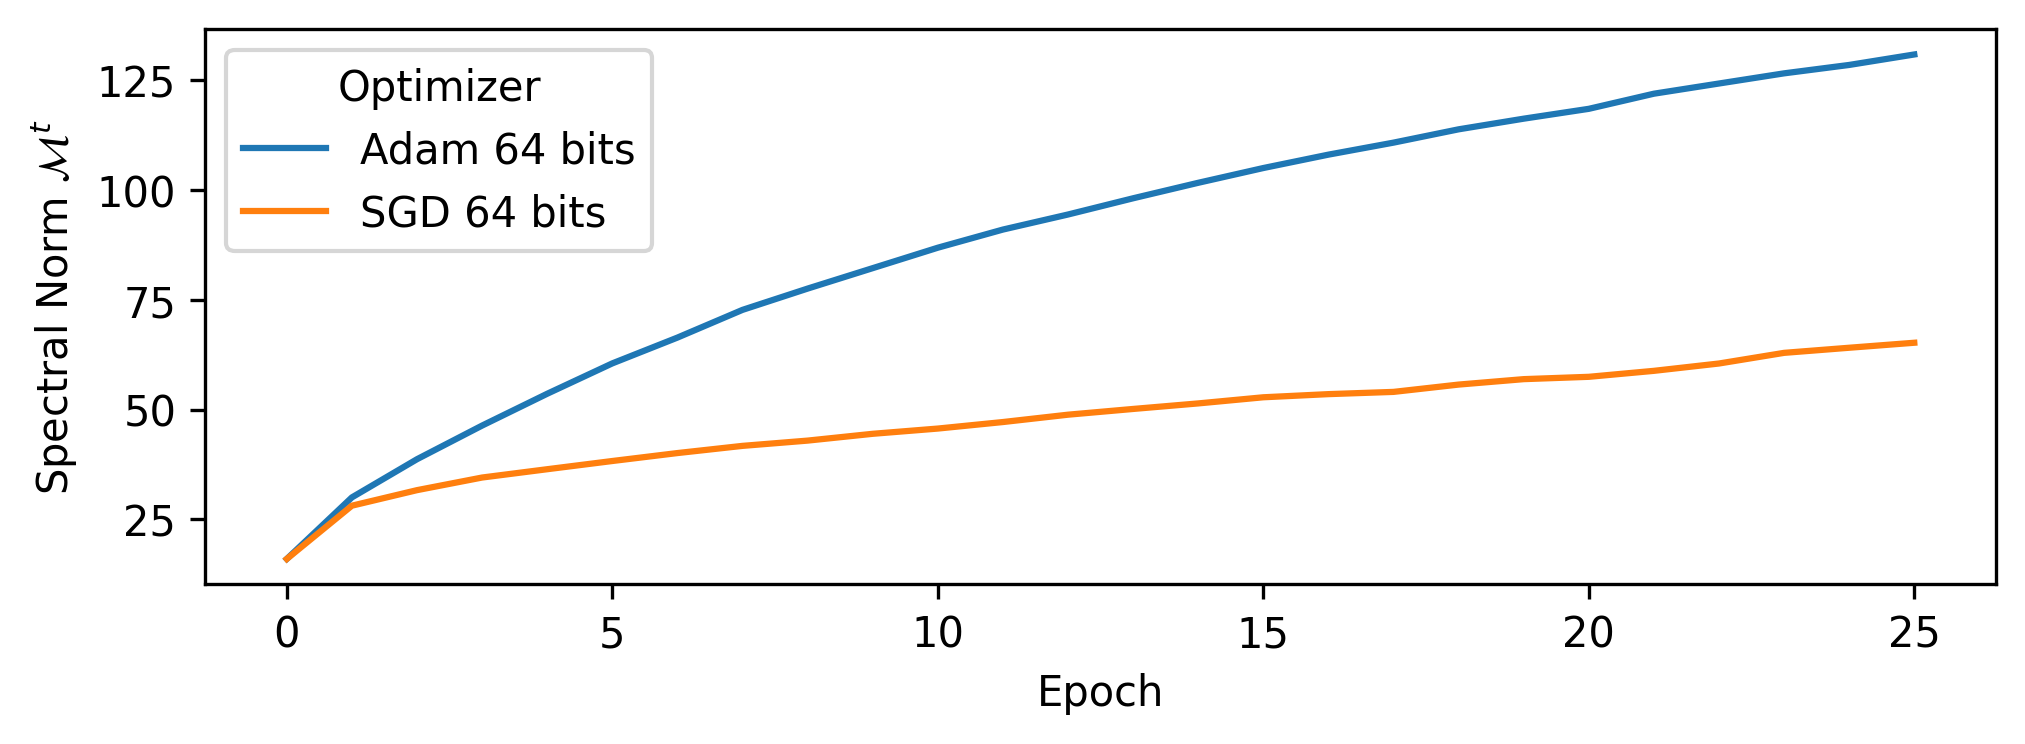

In [ ]:
fig, ax = plt.subplots(figsize=(22*0.35, 7*0.35), dpi=300)
g = sns.lineplot(x=index, y=vals, hue=cols, data=dfm)

In [ ]:
dfm.to_csv(f'divergence_{num_bits}.csv')

## Merge float32 and float64

In [ ]:
dfm32 = pd.read_csv('divergence_32.csv')
dfm32 = dfm32.drop(columns=dfm32.columns[0])
dfm32

,Epoch,Optimizer,Spectral Norm $\mathcal{M}^t$
0,0,Adam 32 bits,16.000542
1,1,Adam 32 bits,30.324541
2,2,Adam 32 bits,39.110847
3,3,Adam 32 bits,46.799461
4,4,Adam 32 bits,53.995857
5,5,Adam 32 bits,60.609196
6,6,Adam 32 bits,67.160538
7,7,Adam 32 bits,72.790085
8,8,Adam 32 bits,78.248039
9,9,Adam 32 bits,83.362534


In [ ]:
dfm64 = pd.read_csv('divergence_64.csv')
dfm64 = dfm64.drop(columns=dfm64.columns[0])
dfm64

,Epoch,Optimizer,Spectral Norm $\mathcal{M}^t$
0,0,Adam 64 bits,16.000542
1,1,Adam 64 bits,30.018700
2,2,Adam 64 bits,38.716732
3,3,Adam 64 bits,46.378811
4,4,Adam 64 bits,53.627213
5,5,Adam 64 bits,60.544743
6,6,Adam 64 bits,66.419792
7,7,Adam 64 bits,72.736778
8,8,Adam 64 bits,77.584129
9,9,Adam 64 bits,82.240593


In [ ]:
dfm_mixed = pd.concat([dfm32, dfm64], axis=0, ignore_index=True)
dfm_mixed

,Epoch,Optimizer,Spectral Norm $\mathcal{M}^t$
0,0,Adam 32 bits,16.000542
1,1,Adam 32 bits,30.324541
2,2,Adam 32 bits,39.110847
3,3,Adam 32 bits,46.799461
4,4,Adam 32 bits,53.995857
...,...,...,...
99,21,SGD 64 bits,58.846817
100,22,SGD 64 bits,60.519264
101,23,SGD 64 bits,62.945007
102,24,SGD 64 bits,64.108963


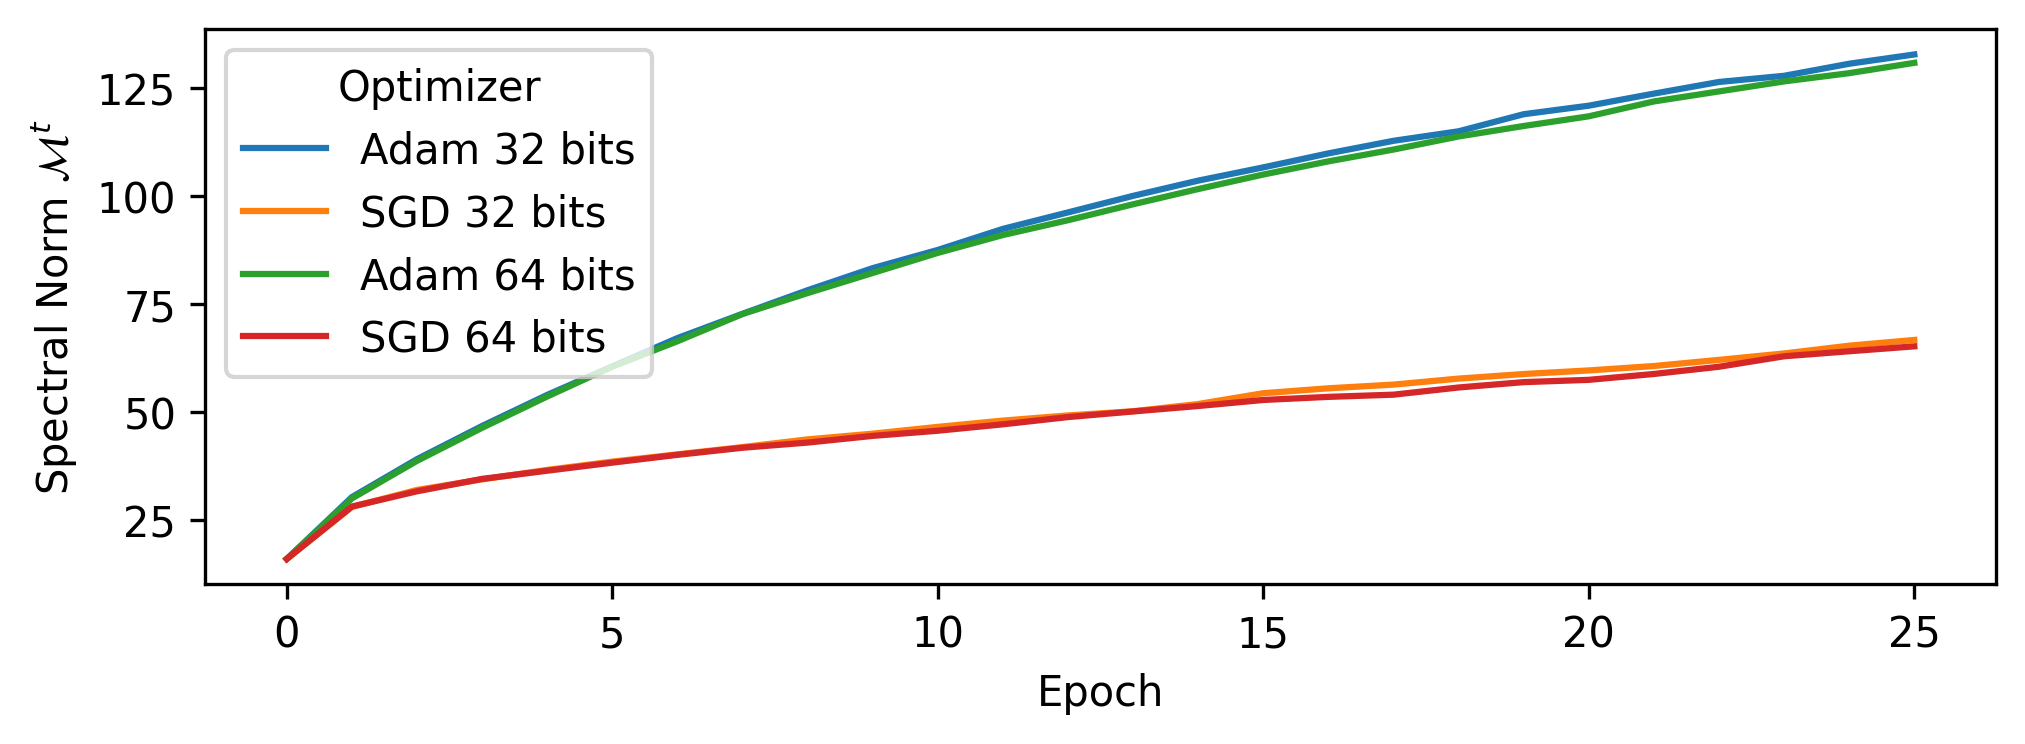

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(22*0.35, 7*0.35), dpi=300)
g = sns.lineplot(x=index, y=vals, hue=cols, data=dfm_mixed)